In [1]:
import torch
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import os
from itertools import count
log_root = '/rxrx/data/user/emmanuel.bengio/logs'

# One such run takes about 4 hours on our cluster
base_hps = {
    'num_training_steps': 20_000,
    'global_batch_size': 64,
    'validate_every': 500,
    'lr_decay': 20000,
    'num_data_loader_workers': 8,
    'temperature_dist_params': 32.0,
    'temperature_sample_dist': 'constant',
    'sampling_tau': 0.99,
    'mp_pickle_messages': True,
}

counter = count(0)
hps = [
    {
        **base_hps,
        'learning_rate': lr,
        'log_dir': f'{log_root}/seh_frag/apr_5_test_{next(counter)}/',
    }  #
    for seed in range(4)  #
    for lr in [3e-4, 1e-4]  #
]

eas = [
    event_accumulator.EventAccumulator(i['log_dir'])
    for i in hps
]

/run/determined/pythonuserbase/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


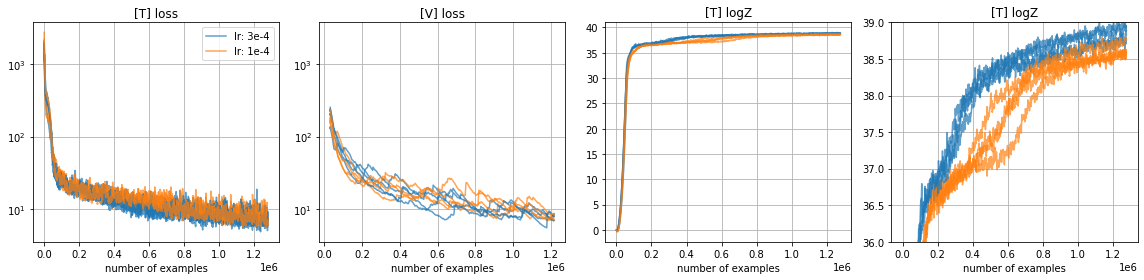

In [2]:
from matplotlib import cm
import matplotlib.pyplot as pp
import pandas as pd
for i in eas:
    i.Reload()
f, ax = pp.subplots(1, 4, figsize=(16, 4))
ax[0].sharey(ax[1])
for k, key in enumerate(['train_loss', 'valid_loss', 'train_logZ', 'train_logZ']):
    pp.sca(ax[k])
    offsets = {}
    asd = 0
    for idx, ea in enumerate(eas):
        sc = ea.Scalars(key)
        df = pd.DataFrame(
            {#'step': np.arange(len(sc)),#np.array([i.step for i in sc]),
             'step': np.array([i.step for i in sc]),
             'value': np.array([i.value for i in sc]),})
        smooth_indicator = ''
        if len(sc) > 200 or 1:
            df = df.ewm(alpha=0.05).mean()
            smooth_indicator = '*'
        pp.plot(df['step'] * hps[idx]['global_batch_size'], 
                df['value'],
                color=cm.tab10(idx % 2),
                alpha=0.7,
                label=('lr: 3e-4' if idx == 0 else 'lr: 1e-4' if idx == 1 else None) if k == 0 else None
               )
        asd += 1
    if k == 0:
        pp.legend()
    if k < 2:
        pp.yscale('symlog', linthresh=1e-4)
    if k == 3:
        pp.ylim(36, 39)
    pp.title(key[:6].replace('train_', '[T] ').replace('valid_', '[V] ') + key[6:])
    pp.xlabel('number of examples')
    pp.grid()
    pp.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    #pp.xscale('symlog', linthresh=1e4)
    #pp.legend()
    #pp.ylim(0, 10)
pp.tight_layout()


In [3]:
import matplotlib.pyplot as pp
import matplotlib.cm as cm
import torch
import tqdm
import gflownet
import determined as det
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import sqlite3
def sqlite_load(root, columns, num_workers=8, upto=None, begin=0):
    try:
        bar = tqdm.tqdm(smoothing=0)
        values = defaultdict(lambda: [[] for i in range(num_workers)])
        for i in range(num_workers):
            con = sqlite3.connect(f'file:{root}generated_mols_{i}.db?mode=ro', uri=True, timeout=6)
            cur = con.cursor()
            cur.execute('pragma mmap_size = 134217728')
            cur.execute('pragma cache_size = -1024000;')
            r = cur.execute(f'select {",".join(columns)} from results where rowid >= {begin}')
            n = 0
            for j, row in enumerate(r):
                bar.update()
                for value, col_name in zip(row, columns):
                    values[col_name][i].append(value)
                n += 1
                if upto is not None and n * num_workers > upto:
                    break
            con.close()
        return values
    finally:
        bar.close()
        
sqlite_cols = ['smi', 'r'] + [f'{a}_{i}' for a in ['fr'] for i in range(1)] + ['ci_beta']

In [4]:
values = [
    sqlite_load(f'/mnt/ps/home/CORP/emmanuel.bengio/project/logs/seh_frag/apr_5_test_{i}/train/', sqlite_cols, 1)
    for i in range(8)
]

160128it [00:00, 341016.67it/s]
160128it [00:00, 380716.13it/s]
160128it [00:00, 378118.98it/s]
160128it [00:00, 376577.88it/s]
160128it [00:00, 385847.09it/s]
160128it [00:00, 364284.31it/s]
160128it [00:00, 367085.90it/s]
160128it [00:00, 371527.71it/s]


In [5]:
from rdkit import Chem
from rdkit import DataStructs
thresh = 0.7
minR = 0.9
all_num_modes = []
for i in range(8):
    num_modes = []
    # This only takers into account the molecules generated by the first worker!
    Rs = values[i]['fr_0'][0]
    smis = values[i]['smi'][0]
    mols = [Chem.MolFromSmiles(x) if r >= minR else None for x, r in zip(smis, Rs)]
    fps = [Chem.RDKFingerprint(x) if x is not None else None for x in mols]
    modes = []
    for j in tqdm.tqdm(range(1, len(fps))):
        if fps[j] is None:
            num_modes.append(len(modes))
            continue
        if len(modes) == 0:
            modes.append(fps[j])
            num_modes.append(len(modes))
            continue
        sims = DataStructs.BulkTanimotoSimilarity(fps[j], modes)
        if all(s < thresh for s in sims):
            modes.append(fps[j])
        num_modes.append(len(modes))
    all_num_modes.append(num_modes)

100%|██████████| 160127/160127 [00:50<00:00, 3162.46it/s] 


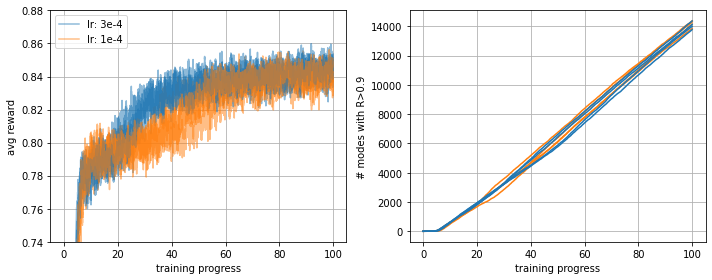

In [9]:
f, ax = pp.subplots(1,2,figsize=(10,4))
pp.sca(ax[0])
for i in range(8):
    L = min([len(i) for i in values[i][f'fr_0']])
    fr_i = np.array([i[:L] for i in values[i][f'fr_0']]).T.flatten()
    df = pd.DataFrame({'step': np.linspace(0, 100, len(fr_i)), 'value': fr_i,})
    df = df.ewm(alpha=0.005).mean()
    pp.plot(df['step'], df['value'], label='lr: 3e-4' if i == 0 else 'lr: 1e-4' if i == 1 else None,
            color=cm.tab10(i % 2), alpha = 0.5)
pp.ylim(0.74, 0.88)
pp.grid()
pp.xlabel('training progress')
pp.ylabel('avg reward')
pp.legend()

pp.sca(ax[1])
for i, nm in enumerate(all_num_modes):
    pp.plot(np.linspace(0, 100, len(nm)), nm, color=cm.tab10(i<4))
pp.ylabel('# modes with R>0.9')
pp.xlabel('training progress')
pp.grid()
pp.tight_layout()